<h1 style="color:red" align="center">Neural Networks: The basics made for all</h1>
<p align="center">By Bastien Lhopitallier and Robin Sobczyk</p>

<h2 style="color:green" align="center">Course 2: How to properly read and present your networks and their results</h2>

In this course, you will learn:
- how to make your results reproducible
  - how to seed your code
  - how to enable reproducibility on GPU
  - what are the uncontrollable factors that might undermine your reproducibility
  - how much providing source code is necessary
- how to analyse the results of your network
  - what is overfitting and underfitting
  - how to identify them
- how to represent your network to present it to other people
  - how to read and create the computation flow of a neural network
  - how to represent neural networks from that control flow
- how to avoid common problems
  - what is gradient vanishing and exploding
  - how to use gradient inspection to locate them

<h3 style="color:red">About Google Colab</h3>

Running notebooks on Google Colab is not necessarily easy, specifically when these notebooks have environment requirements. The following cell should detect if you are running this notebook on Google Colab, and if it is the case, it should enable what is required so that the notebook can run without failing.

Beware that these notebooks are not intrinsically made for Google Colab, and that Google Colab will break the notebook layout and prevent the static pictures from showing. However, this will not prevent the code from executing properly. If you decide to run on Colab (which can be useful to get GPUs), we hence recommend that you follow the results you might get on Colab along with a local version of this notebook, so that you can enjoy both the computation speed and the initial course layout and content.

The time of execution of this notebook is estimated to be about 45 mins on GPU. We hence recommend using Google Colab if you have no GPU available.

In [ ]:
import os

colab_script = r"""git clone https://github.com/RobinSobczyk/Teaching-Initiation_to_Neural_Networks
mv ./Teaching-Initiation_to_Neural_Networks/toolbox ./
rm -r ./Teaching-Initiation_to_Neural_Networks
apt install graphviz libgraphviz-dev
pip install pygraphviz
pip install ipympl"""

on_colab = os.getenv("COLAB_RELEASE_TAG") is not None
if on_colab :
    os.system(colab_script)
    from google.colab import output
    output.enable_custom_widget_manager()

<h3 style="color:skyblue">Reproducibility</h3>

Before claiming anything about your results, you have to ensure anyone who applies the same method as you will get the same results. Results that have only been seen by you and that can't be reproduced by anyone are worthless. Anyone can claim they have seen the Loch Ness Monster, but if you want to show everyone it exists, you have to provide people a way to see it directly for themselves. Reproducibility is about the same.

Moreover, in Computer Science, almost everything can be controlled, and making a fully reproducible result is most often not that hard. Also, reproducible results don't mean there is nothing random and that any statistical result is biased. It means, randomness should be controlled and statistical results should be extracted from samples large enough to be statistically significant.

<h4 style="color:DarkViolet">Controlled randomness</h4>

Thanks to random number generators, it is today possible to generate a sequence of random numbers that can be reproduced. Quickly, a Random Number Generator (RNG) is a process that holds an internal state and that output results when asked to. Asking for the RNG to output a result will update its internal state. Given a state, the RNG will always output the same result. When asking for several results, the trajectory of the internal state is such that the sequence of the results is seemingly random.

Hence, it is possible to generate apparently random results with reproducibility. Setting a RNG to a given state is called *seeding*, and the initial state is the *seed*.  
Seeding a RNG that will be used all along your code is necessary to ensure that the results are reproducible. PyTorch provides good ways to seed your code.

In [ ]:
seed = 3407

# PyTorch seeding

import torch

torch.manual_seed(seed)

In PyTorch, you can use the RNG to control the parameter initialisation in your model, to control the shuffling in your dataloader, to control most random things. More than that, you can provide different RNGs to different objects, each generator having its own seed. It is worth to notice that you might need to seed more than PyTorch depending on your code. You might need to seed other modules (like NumPy), or even seed Python or make your code rely on controlled RNG if you use custom codes.

In [ ]:
import random

import numpy as np

# Seeding Python random module
random.seed(seed)

# Seeding NumPy
np.random.seed(seed)

However, seeding is not always sufficient to ensure reproducibility.

<h4 style="color:DarkViolet">Non-deterministic routines</h4>

Sometimes, the functions you use are not deterministic. Most often, this non-determinism is due to optimizations. It is specifically the case about convolutions on GPUs relying on the CUDA backend (i.e. most cases of convolution on GPUs). It is important to know that these kinds of behaviors exist, and to not be surprised that only seeding doesn't provide full reproducibility.

PyTorch provide some functions to limit those effects. You can read more about them [here](https://pytorch.org/docs/stable/notes/randomness.html).

In [ ]:
# Setting PyTorch algos to reproducible
torch.use_deterministic_algorithms(True)

However, sometimes, your computations don't only rely on PyTorch. Sometimes, PyTorch itself uses other backends, like cuBLAS, that require their own configuration. See [cuBLAS documentation](https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility) for more information on that. CuBLAS is used by PyTorch for RNNs. In any case, it is your responsibility to look for sources of non-deterministic behaviours in your code and to either controll them or warn about them.

In [ ]:
import os

if torch.cuda.is_available():
    cuda_version = list(map(int, torch.version.cuda.split(".")))
    if cuda_version[0] == 10:
        if cuda_version[1] == 1:
            os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
        if cuda_version[1] > 1:
            os.environ["CUBLAS_WORKSPACE_CONFIG"] = (
                ":4096:8"  # setting CUBLAS_WORKSPACE_CONFIG=:16:8 also works
            )
    elif cuda_version[0] > 10:
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = (
            ":4096:8"  # setting CUBLAS_WORKSPACE_CONFIG=:16:8 also works
        )
    else:
        raise RuntimeError(
            f"CUDA version {torch.version.cuda} might be too old to support deterministic behavior"
        )

<h4 style="color:DarkViolet">Multi-threading</h4>

Quite often in deep learning, it is useful to parallelize your computations. It allows your experiments to run faster, and to leverage the technical progress that chip makers often bring to the market. Parallelization is often done by dispatching your work over multiple CPUs and GPUs. This is called multithreading.

However, most often, parameters from your code don't completely broadcast from a thread to another. Hence, it is important in such cases that you ensure that any of your workers (understand, every part of your code on separate threads) will be properly seeded and have their non-determinism controlled. In PyTorch, most classes that can use multithreading will include an argument `worker_init_fn` which allows to provide a function to intialize your workers in a reproducible way.

In [ ]:
# example of init function to ensure all workers will have the same seed in multithreading
def reproducible_worker_init_fn(worker_id):
    torch.manual_seed(seed)

However, multithreading is one more cause of non-determinism in certain precise contexts. Specifically, if your computations are asynchronous, it is possible that differences in thread attributions combined to physical thread differences lead to different results. This part is really hard to control, and is most often left as is, but mentioned to be acknowledged by the readers of your results.

Other physical effects might prevent complete reproducibility, like heat inducing computation errors randomly in processors, or even [cosmic rays flipping bits in your computer](https://en.wikipedia.org/wiki/Single-event_upset) if you are really unlucky. Yes, it happens. But it is unlikely to happen 5 times in a row though, so always rerun your code a few times to check your results yourself.

<h4 style="color:DarkViolet">The necessity of available source code</h4>

With all those tools, you are now able to produce near-completely reproducible results. And this is good, but not enough. It's not because you're able to produce photos of Nessie consistently that you just don't have a rigged camera. This is why providing source code is necessary.

With source code available, people will be able to reproduce your results from scratch, and see for themselves that none of what you did is made up. If needed, readers can even read your code in depth to understand the most technical details.
Furthermore, it is good practice to provide, along with your code, some scripts and simple indications that readers can follow easily to run the exact same experiment. Think how easier it is to just double click on an executable to generate results than having to look everywhere in the source code for the necessary parts and rewrite a complete experiment, even if the recipe is written somewhere. Always think that your readers will be lazy, and you want them to be able to reproduce your results the simplest way. They might not be lazy in fact, but they might not have enough time to look everywhere in your code to rerun your experiments, and giving them everything they need on a platter is really enjoyable for them.

Also, do not fear that providing source code means giving your work away for free to anyone. You can always add a license to your code (as is done for these courses). Licenses by nature are contracts between you and people that might use your code. While licensing is not the core of this course, it is good to know a bit about [them](https://en.wikipedia.org/wiki/Software_license). If there's anything to retain, you can always release your code with a very restrictive license to ensure that the common people are not allowed to use your code, and then provide (or even sell) less restrictive license to specific entities or people. This is called multi-licensing, and is mandatory in most cases.

<h3 style="color:skyblue">Analysing the results of a neural network</h3>

Analysing the results of a neural network is always something non-trivial. Most often, you are trying to show that it succeeds at generalizing a certain task, should it be correctly classifying data, scoring them, reacting the right way in given situations etc.

It is obviously wrong to claim results only from training data, as the network might have learned them enough to not do any error on the training set. However, as philosophically you only access the test set once, it is hard to ensure that your network will generalize well on the test set without accessing it beforehand. This is where the validation set comes in handy, it allows you to check how much your network is able to generalize on a set of data on which it never trained.

To understand the necessity of tracking the training of a network over training and validation data, we will first design a model and train it to see what happens.

First, we will use a common dataset called [CIFAR 10](https://www.cs.toronto.edu/~kriz/cifar.html). This dataset is composed of 60000 32x32 color images split into 10 classes (6000 images per class). The data are naturally split into a train set (50000 images) and a test set (10000 images).

It is then a classifying task, given a picture, the network has to predict which class is depicted. Hence, the pictures are to be classified in the following classes :
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

<b style="text-decoration:underline;color:red">Important :</b> It is always necessary to mention which dataset you are using and citing the source which introduced it, and if the dataset is a bit uncommon, to describe what it is made of, what is the underlying task etc.

In [ ]:
# First, we will download and import the datasets, torchvision package from PyTorch include routines for CIFAR10

from pathlib import Path

import torchvision
from torchvision import transforms

cifar_dataset_directory = Path("./datasets/CIFAR10")
cifar_dataset_directory.mkdir(parents=True, exist_ok=True)

cifar_train_set = torchvision.datasets.CIFAR10(
    root=cifar_dataset_directory,
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)
cifar_test_set = torchvision.datasets.CIFAR10(
    root=cifar_dataset_directory,
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

Now, we will explore some examples of the dataset to know what it looks like.

In [ ]:
# Code to show some example
import matplotlib.pyplot as plt


def plot_sample_grid(dataset, num_sample_per_class, seed):
    samples = dataset.data
    classes = np.array(dataset.targets)
    all_classes = dataset.classes

    generator = np.random.default_rng(
        seed
    )  # needed to make np.random.choice reproducible

    id_by_classes = []
    for i, class_name in enumerate(all_classes):
        sample_ids = generator.choice(
            np.argwhere(classes == i).flatten(), num_sample_per_class
        )
        id_by_classes.append((class_name, sample_ids))

    fig, axarr = plt.subplots(
        len(all_classes),
        num_sample_per_class + 1,
        gridspec_kw={
            "width_ratios": [
                0 if i == 0 else 1 for i in range(num_sample_per_class + 1)
            ]
        },
    )
    for i, class_samples in enumerate(id_by_classes):
        class_name, sample_ids = class_samples
        axarr[i, 0].yaxis.set_label_position("left")
        axarr[i, 0].spines["left"].set_position(("axes", -0.4))
        axarr[i, 0].spines["left"].set_visible(False)
        axarr[i, 0].spines["right"].set_visible(False)
        axarr[i, 0].spines["top"].set_visible(False)
        axarr[i, 0].spines["bottom"].set_visible(False)
        axarr[i, 0].set_yticks([])
        axarr[i, 0].set_xticks([])
        axarr[i, 0].set_ylabel(
            class_name, rotation=0, size="large", ha="right", va="center"
        )
        for j, sample_id in enumerate(sample_ids):
            img = samples[sample_id]
            axarr[i, j + 1].imshow(img)
            axarr[i, j + 1].axis("off")
    fig.set_figheight(10)
    fig.set_figwidth(10)
    fig.tight_layout()


plot_sample_grid(cifar_train_set, 10, seed)

We will then split the training data into a training set and a validation set.

In [ ]:
# Splitting the data
from torch.utils.data import random_split

generator = torch.Generator().manual_seed(seed)  # needed for reproducibility
effective_cifar_train_set, cifar_val_set = random_split(
    cifar_train_set,
    [len(cifar_train_set) - len(cifar_train_set) // 10, len(cifar_train_set) // 10],
    generator=generator,
)

# Verifying proportions
val_tot_classes = np.bincount(np.array(cifar_train_set.targets)[cifar_val_set.indices])
for i, class_name in enumerate(cifar_train_set.classes):
    print(f"{val_tot_classes[i]} samples of class {class_name} in validation set")

In order to be able to shuffle our data for training, we will put our dataset in dataloaders.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_generator = torch.Generator().manual_seed(
    seed
)  # allows shuffling the training data in a reproducible way

# Define a dataloader on the effective train set with seeded shuffling using the train_generator

# === YOUR CODE ===
cifar_trainloader = ...
# =================

cifar_valloader = DataLoader(dataset=cifar_val_set, batch_size=batch_size)

cifar_testloader = DataLoader(dataset=cifar_test_set, batch_size=batch_size)

And now, we will design a model, and choose a loss and an optimizer. As we are doing classification, we can use an usual classification loss like Cross Entropy or Negative Log-Likelihood (note that Cross Entropy is the same as applying NLL after a logsoftmax). For the optimizer, as nothing hints toward a specific choice, we recommend :
1. AdamW : but it uses lots of memory
2. Adam : no theoretical guarantee that it will converge
3. SGD with momentum : might require longer training
4. Classic SGD : converges the slowest, but takes the least memory

Here, we'll choose Cross Entropy and AdamW. We can now design our model. We will first go for the simplest, and design a simple fully-connected network.

In [ ]:
# Model

import torch.nn as nn
import torch.nn.functional as F


class MyFCModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # A network with 4 linear layers, input dimension is 3072, hidden dimensions are, in order, 1536, 768, 128, and output dimension is 10

        # === YOUR CODE ===
        ...
        # =================

    def forward(self, inputs: torch.Tensor):
        # Forward pass, start by flattening all dimensions except the batch dimensions (images are of size 32x32x3 = 3072)
        # activation function is ReLU, and is used for all layers except the last on

        # === YOUR CODE ===
        ...
        # =================


fc_network = MyFCModel()

In [ ]:
# Loss and optimizer

import torch.optim as optim

optimizer = optim.AdamW(params=fc_network.parameters())
loss = nn.CrossEntropyLoss()

As seen in the previous course, we will design a training loop

In [ ]:
# Training loop


def train(
    model: nn.Module,
    optimizer: optim.Optimizer,
    loss: nn.Module,
    trainloader: DataLoader,
    testloader: DataLoader,
    data_to_track: list[tuple[str, DataLoader]],
    num_epochs: int,
    device: torch.device,
    verbose: bool = False,
) -> tuple[float, float, dict[str, list[float]], dict[str, list[float]]]:
    model.to(device=device)
    with torch.no_grad():

        # Initializing losses and accuracies

        losses = {"train": []}
        accuracies = {"train": []}

        for dataset_name, _ in data_to_track:
            losses[dataset_name] = []
            accuracies[dataset_name] = []

        for epoch in range(num_epochs):

            # training
            with torch.enable_grad():
                model.train()

                temp_acc = 0
                temp_losses = []
                for batch_id, (batch_data, batch_truth) in enumerate(trainloader):

                    # forward pass, don't forget to put data on the correct device

                    # === YOUR CODE ===
                    out = ...
                    # =================

                    # set gradients to zero

                    # === YOUR CODE ===
                    ...
                    # =================

                    loss_value = loss(out, batch_truth.to(device))

                    # get the predicted classes
                    # the predicted class of a sample is the id of the dimension containing the highest score

                    # === YOUR CODE ===
                    predicted_classes = ...
                    # =================

                    temp_acc += (
                        torch.sum(predicted_classes == batch_truth.to(device))
                        .cpu()
                        .numpy()
                    )
                    temp_losses.append(loss_value.detach().cpu().numpy())

                    # compute the gradients and do a gradient step

                    # === YOUR CODE ===
                    ...
                    # =================

                    if verbose and ((batch_id + 1) % 100) == 0:
                        print(
                            f"Epoch[{epoch+1}/{num_epochs}], train batch[{batch_id+1}/{len(trainloader)}], loss : {loss_value.item()}"
                        )
                accuracies["train"].append(temp_acc / len(trainloader.dataset))
                losses["train"].append(np.mean(temp_losses))

            # data tracking across epochs, e.g. validation
            model.eval()
            for current_dataset_name, current_dataloader in data_to_track:
                temp_acc = 0
                temp_losses = []
                for batch_id, (batch_data, batch_truth) in enumerate(
                    current_dataloader
                ):

                    # compute the output and the predicted classes

                    # === YOUR CODE ===
                    out = ...
                    predicted_classes = ...
                    # =================

                    loss_value = loss(out, batch_truth.to(device))
                    temp_acc += (
                        torch.sum(predicted_classes == batch_truth.to(device))
                        .cpu()
                        .numpy()
                    )
                    temp_losses.append(loss_value.detach().cpu().numpy())
                    if verbose and ((batch_id + 1) % 10) == 0:
                        print(
                            f"Epoch[{epoch+1}/{num_epochs}], {current_dataset_name} batch[{batch_id+1}/{len(current_dataloader)}], loss : {loss_value.item()}"
                        )
                accuracies[current_dataset_name].append(
                    temp_acc / len(current_dataloader.dataset)
                )
                losses[current_dataset_name].append(np.mean(temp_losses))

        # test
        model.eval()
        temp_acc = 0
        temp_losses = []
        for batch_id, (batch_data, batch_truth) in enumerate(testloader):

            # compute the output and the predicted classes

            # === YOUR CODE ===
            out = ...
            predicted_classes = ...
            # =================

            loss_value = loss(out, batch_truth.to(device))
            temp_acc += (
                torch.sum(predicted_classes == batch_truth.to(device)).cpu().numpy()
            )
            temp_losses.append(loss_value.detach().cpu().numpy())
            if verbose and ((batch_id + 1) % 10) == 0:
                print(
                    f"test batch[{batch_id+1}/{len(testloader)}], loss : {loss_value.item()}"
                )
        testloss = np.mean(temp_losses)
        testacc = temp_acc / len(testloader.dataset)

    return testloss, testacc, losses, accuracies

We will now train it. For educational purposes, we will also track down the accuracy over the test set, but remember that these are data we shouldn't have access to in everyday contexts.

In [ ]:
# Selecting device for compute

if torch.cuda.is_available():
    cuda_count = torch.cuda.device_count()
    print(f"{cuda_count} CUDA device(s) available")
    print("list of CUDA devices :")
    for i in range(cuda_count):
        print(f"- device {i} : {torch.cuda.get_device_name(i)}")
    print(
        f"Current CUDA device : device {torch.cuda.current_device()} : {torch.cuda.get_device_name(torch.cuda.current_device())}"
    )
else:
    print("CUDA not available")
device = torch.device(
    f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu"
)

In [ ]:
# Training

testloss, testacc, losses, accuracies = train(
    model=fc_network,
    optimizer=optimizer,
    loss=loss,
    trainloader=cifar_trainloader,
    testloader=cifar_testloader,
    data_to_track=[("validation", cifar_valloader), ("test", cifar_testloader)],
    num_epochs=30,
    device=device,
    verbose=True,
)

Now we will explore the results.

In [ ]:
# Function to print results


def print_results(
    testloss: float,
    testacc: float,
    losses: dict[str, list[float]],
    accuracies: dict[str, list[float]],
):
    print(f"Final loss on test set is {testloss} and accuracy is {testacc}")
    fig, ax = plt.subplots(1, 2)
    for dataset_name in losses.keys():
        ax[0].plot(losses[dataset_name], label=dataset_name)
        ax[1].plot(accuracies[dataset_name], label=dataset_name)
    ax[0].legend()
    ax[1].legend()
    ax[0].title.set_text("Losses")
    ax[1].title.set_text("accuracies")
    ax[1].set_ylim([0, 1])
    ax[0].set_xlabel("epochs")
    ax[1].set_xlabel("epochs")
    fig.set_figheight(7)
    fig.set_figwidth(21)
    fig.tight_layout()

In [ ]:
# The results

print_results(testloss, testacc, losses, accuracies)

Training on 200 epochs gives the following curves :

<div style="max-width:1400px;margin-right: auto; margin-left: auto;">

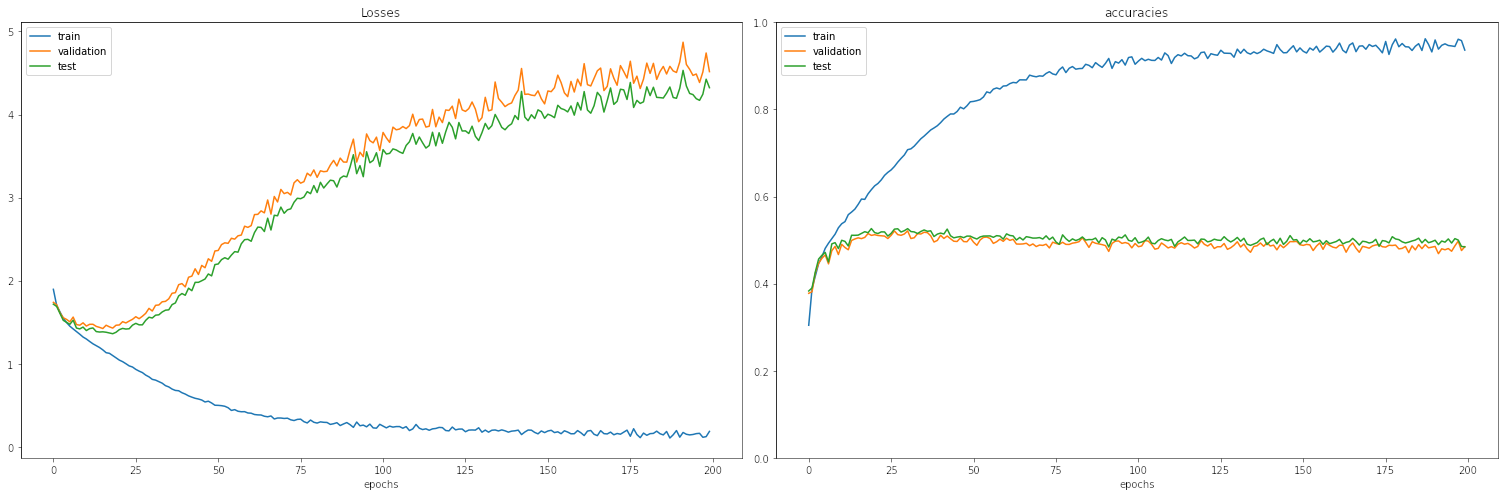

</div>

On these results, we can see several things. The first one, which is quite important, is that a good validation set provides accurate predictions for the test set, provided that the validation set and the test set follow the same distribution. Hence, accessing the test set before the end is not needed, and there is only a need to design a good validation set.

The second one, which allows to pick the best version of your model for testing, is what is called underfitting/overfitting :
- Up until epoch ~15, the validation loss curve is going down, the network has not finished training, the network is still not fit, this is called underfitting.
- After epoch 15, the validation loss curve is going up, although the network is still training (the training loss curve still goes down). What happens here is that the network starts to learn the training set too hard. It becomes so specialized on the training set it begins to lose its ability to generalize. It fits too well for the training set, it is overfitting. It is important to note that accuracy on validation and test set degrades as well, not only the loss.

What should be retained from this is that it is only useful to train the model until the validation loss starts to go up. There is no need to reach the highest possible accuracy on training data, there is no need to reach a stability of any sort, etc.

<h3 style="color:skyblue">Presenting your network and your results</h3>

<h4 style="color:DarkViolet">Presenting your results</h4>

Presenting your results is most often quite easy. You can often just throw the performances of your model as is and compare them to values from other models. Note that cherry picking, i.e. trying the experiment multiple times and retaining only the best results, is close to intellectual dishonesty. This is why it is important to access the test set only once per model, and use the validation set to pick the best version of your model.

It is also important to know that performances may vary with the seed, and that sometimes this variation is significant. This [article](https://arxiv.org/abs/2109.08203) sums it up with examples. The best way to present your results is:
- if you ran your experiment once, then say you did, and provide the seeds for everything
- if you ran the experiment multiple times, then aggregate the results as statistics (mean, variance, etc), and provide decent explanations on your method to aggregate your results. Here also, code for reproduction is good practice.

For example, it is possible that the same model overfits at different epochs for different seeds, and that you (righteously) didn't pick the same epoch for all the seeds. It is mandatory to explain it. It is also possible that given different seeds, the optimal hyperparameters (learning rate, momentum, etc) are not the same. In this case, again, provide the method used for hyperparameter selection, and ways to reproduce the results.

In [ ]:
# Running the same training across different seeds

num_tests = 10

seed_generator = torch.Generator().manual_seed(42)
seeds = [seed_generator.seed() for _ in range(num_tests)]

old_state = torch.get_rng_state()
accuracies_across_seeds = []
losses_across_seeds = []
for i, exp_seed in enumerate(seeds):

    # seed PyTorch with exp_seed, then create a MyFCModel instance along its optimizer
    # then train that model for 15 epochs using the train function previously coded
    # keep the loss and accuracy after training respectively as exp_loss and exp_acc

    # === YOUR CODE ===
    ...
    # =================

    accuracies_across_seeds.append(exp_acc)
    losses_across_seeds.append(exp_loss)
    print(f"Experiment {i+1}/{num_tests} : loss : {exp_loss} | accuracy : {exp_acc}")
torch.set_rng_state(old_state)

In [ ]:
# Plotting the results


def print_var_results(
    losses,
    accuracies,
):
    fig, ax = plt.subplots(1, 2)
    ax[0].hist(losses, bins=15)
    ax[1].hist(accuracies, bins=15)
    ax[0].set_xlabel("Loss")
    ax[1].set_xlabel("Accuracy")
    ax[0].set_ylabel("Count")
    ax[1].set_ylabel("Count")
    ax[0].title.set_text("Losses histogram")
    ax[1].title.set_text("Accuracies histogram")
    fig.set_figheight(7)
    fig.set_figwidth(21)
    fig.tight_layout()


print_var_results(losses_across_seeds, accuracies_across_seeds)

Running the same code over 1000 seeds instead of 10 gives the following distributions :

<div style="max-width:1600px;margin-right: auto; margin-left: auto;">

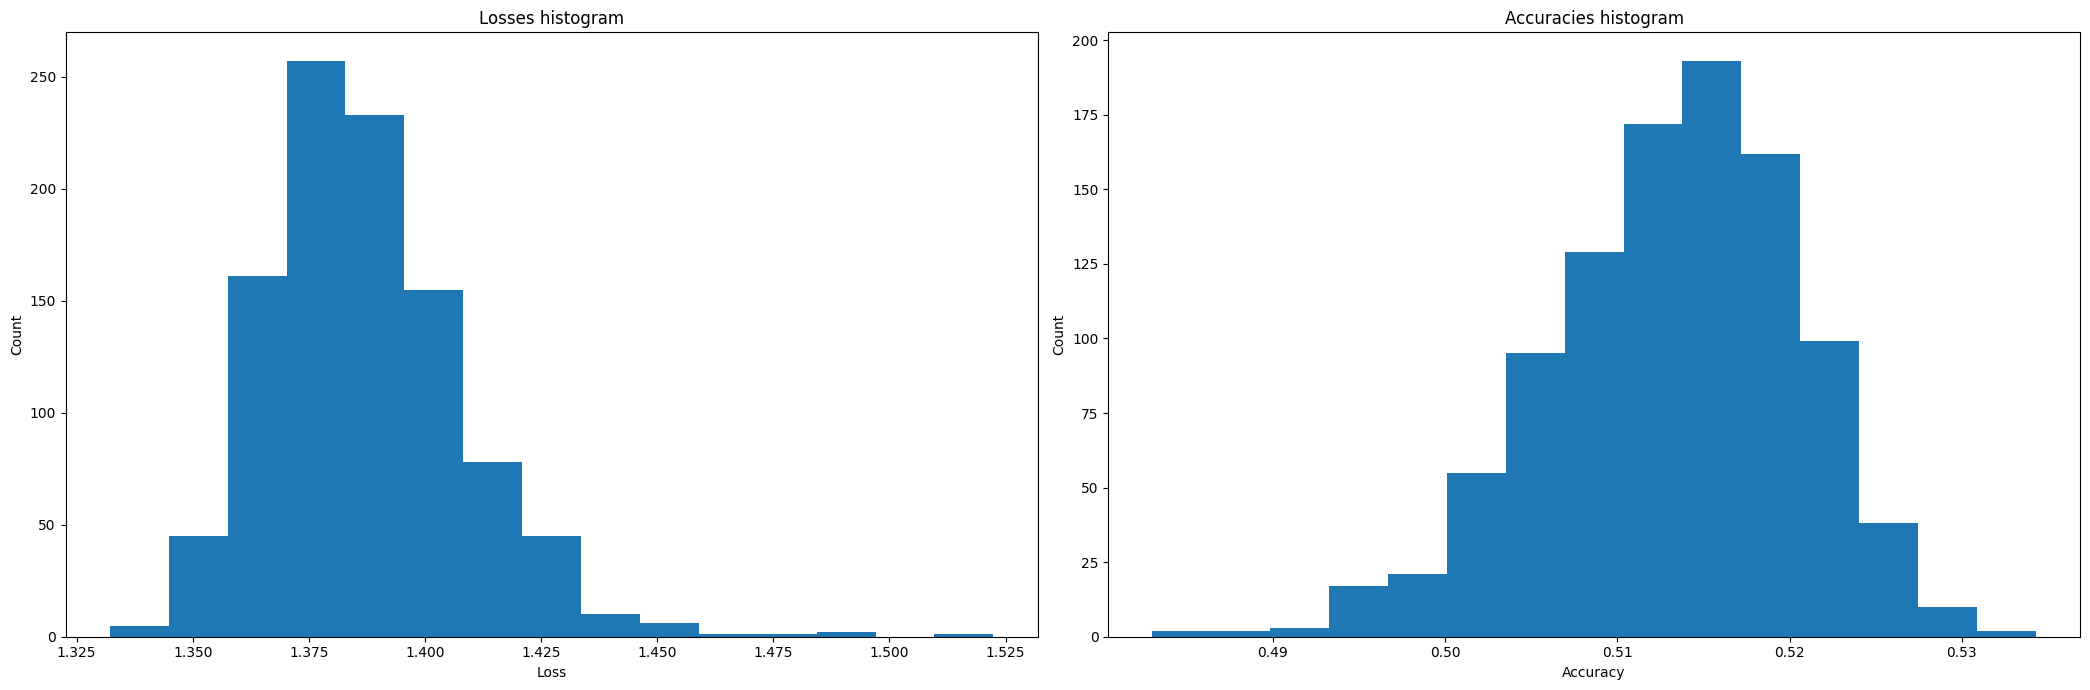

</div>

Here, we can see that the accuracy can easily vary of 2 points. 2 points in accuracy is sometimes enough for a publication on certain datasets, so it is mandatory to check that your performance is not a lucky shot, but is indeed representative of the performance of your model. On the contrary, it is also important to not be discouraged by one bad result, as it might just be a bad seed, and again, checking the average performance is necessary.

<h4 style="color:DarkViolet">Presenting your network</h4>

Presenting the performance of your model is not enough though. It is important for science and progress to be able to understand what is new in your network and how that makes it special enough for your results to become valuable. Hence, it is necessary to present your network, and the best way to do it is to provide 3 things:
- the computation flow of your network, also called architecture
- the loss and optimizer you used
- the hyperparameters you used

While naming the loss and optimizer (if you use standards one) is enough, and an array of hyperparameters is also sufficient, describing your model with words and equations often takes much more space than needed. Hence, it is possible to visualize your network.

For this course, we provide tools to automatically generate computation flow for most networks. We won't get into the details of this code as this is not the purpose of this course, and only use its features.

In [ ]:
# Code for computation flow

from toolbox.torch_graph import BridgeGraph

graphed_fc_network = BridgeGraph(fc_network)

fc_fig = graphed_fc_network.plot(10, 10)

However the code provided in this course doesn't handle recurrent neural networks (loops) and dynamic control flow, i.e. when the sequence of operations depends on data included in the input and not solely on the parameters. Those technical limitations are due to [`torch.fx`](https://pytorch.org/docs/stable/fx.html#limitations-of-symbolic-tracing) not supporting these features.

Also, while this code allows for a quick and readable representation of your network, this representation isn't graceful enough to be included in publications. It is then useful to translate them in handmade diagrams, for which we recommend [draw.io](https://app.diagrams.net/). You can then convert the previous figure in this one :

<div style="max-width:1200px;margin-right: auto; margin-left: auto;">

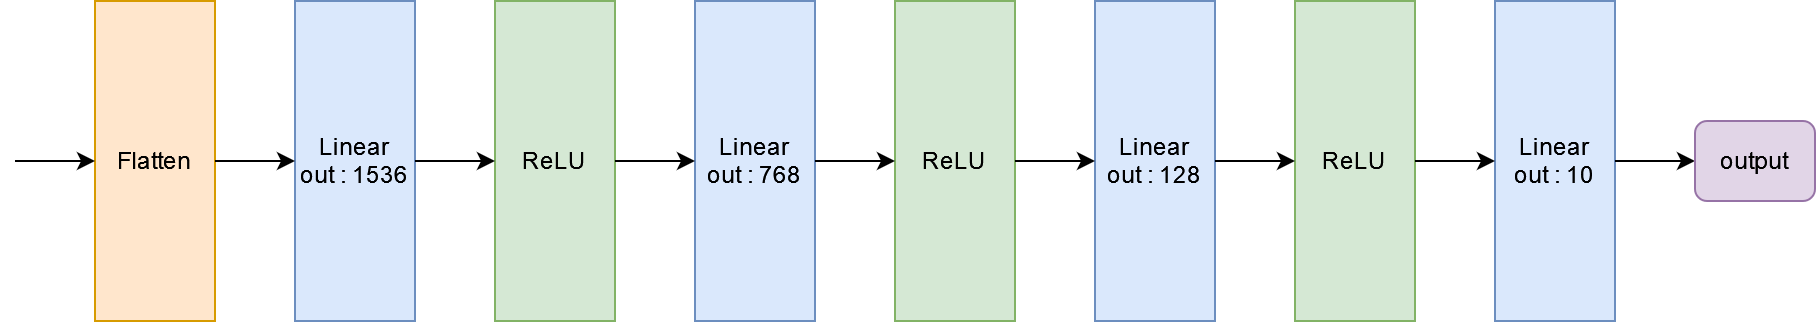

</div>

There are conventions for such drawings. Most often, only layers and links between them are represented. However, in some contexts, other representations can be found. This is mostly the case for convolution networks and linear networks.

<div style="max-width:1000px;margin-right: auto; margin-left: auto;">

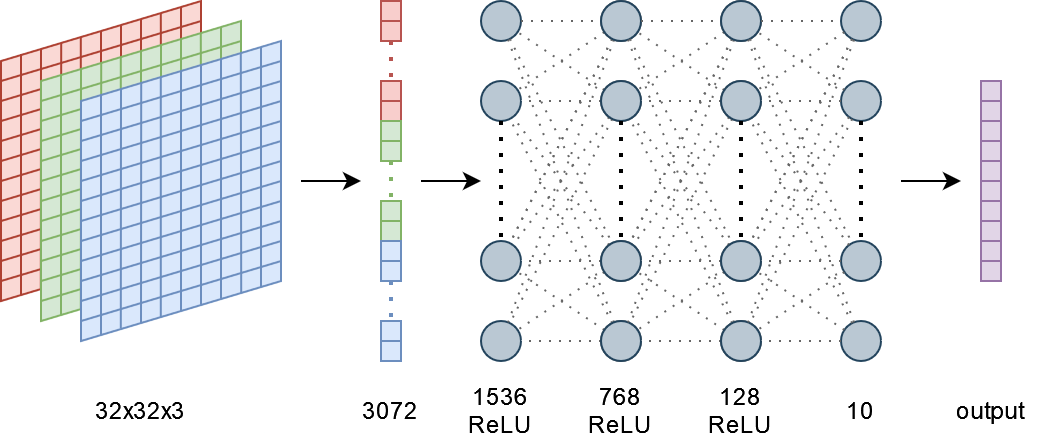

</div>

For educational purposes, we will use a Convolution Neural Network and provide the different representations it has. The architecture is ResNet for CIFAR, found it the paragraph 4.2 of [the ResNet article](https://doi.org/10.1109/CVPR.2016.90).

In [ ]:
# Example of CNN

from toolbox.network_gen import CifarResNet

resnet20 = CifarResNet(n=3, out_dim=10)

# Automatic control flow representation

# from the code used to represent the linear network earlier, get a representation of the computation graph of resnet20

# === YOUR CODE ===
...
# =================

However, we can see here that a lot of informations are missing about the convolution parameters, and the diagram is a bit long. Hence, we can again reuse that first diagram to make the following more precise and more readable diagram.

<div style="max-width:1200px;margin-right: auto; margin-left: auto;">

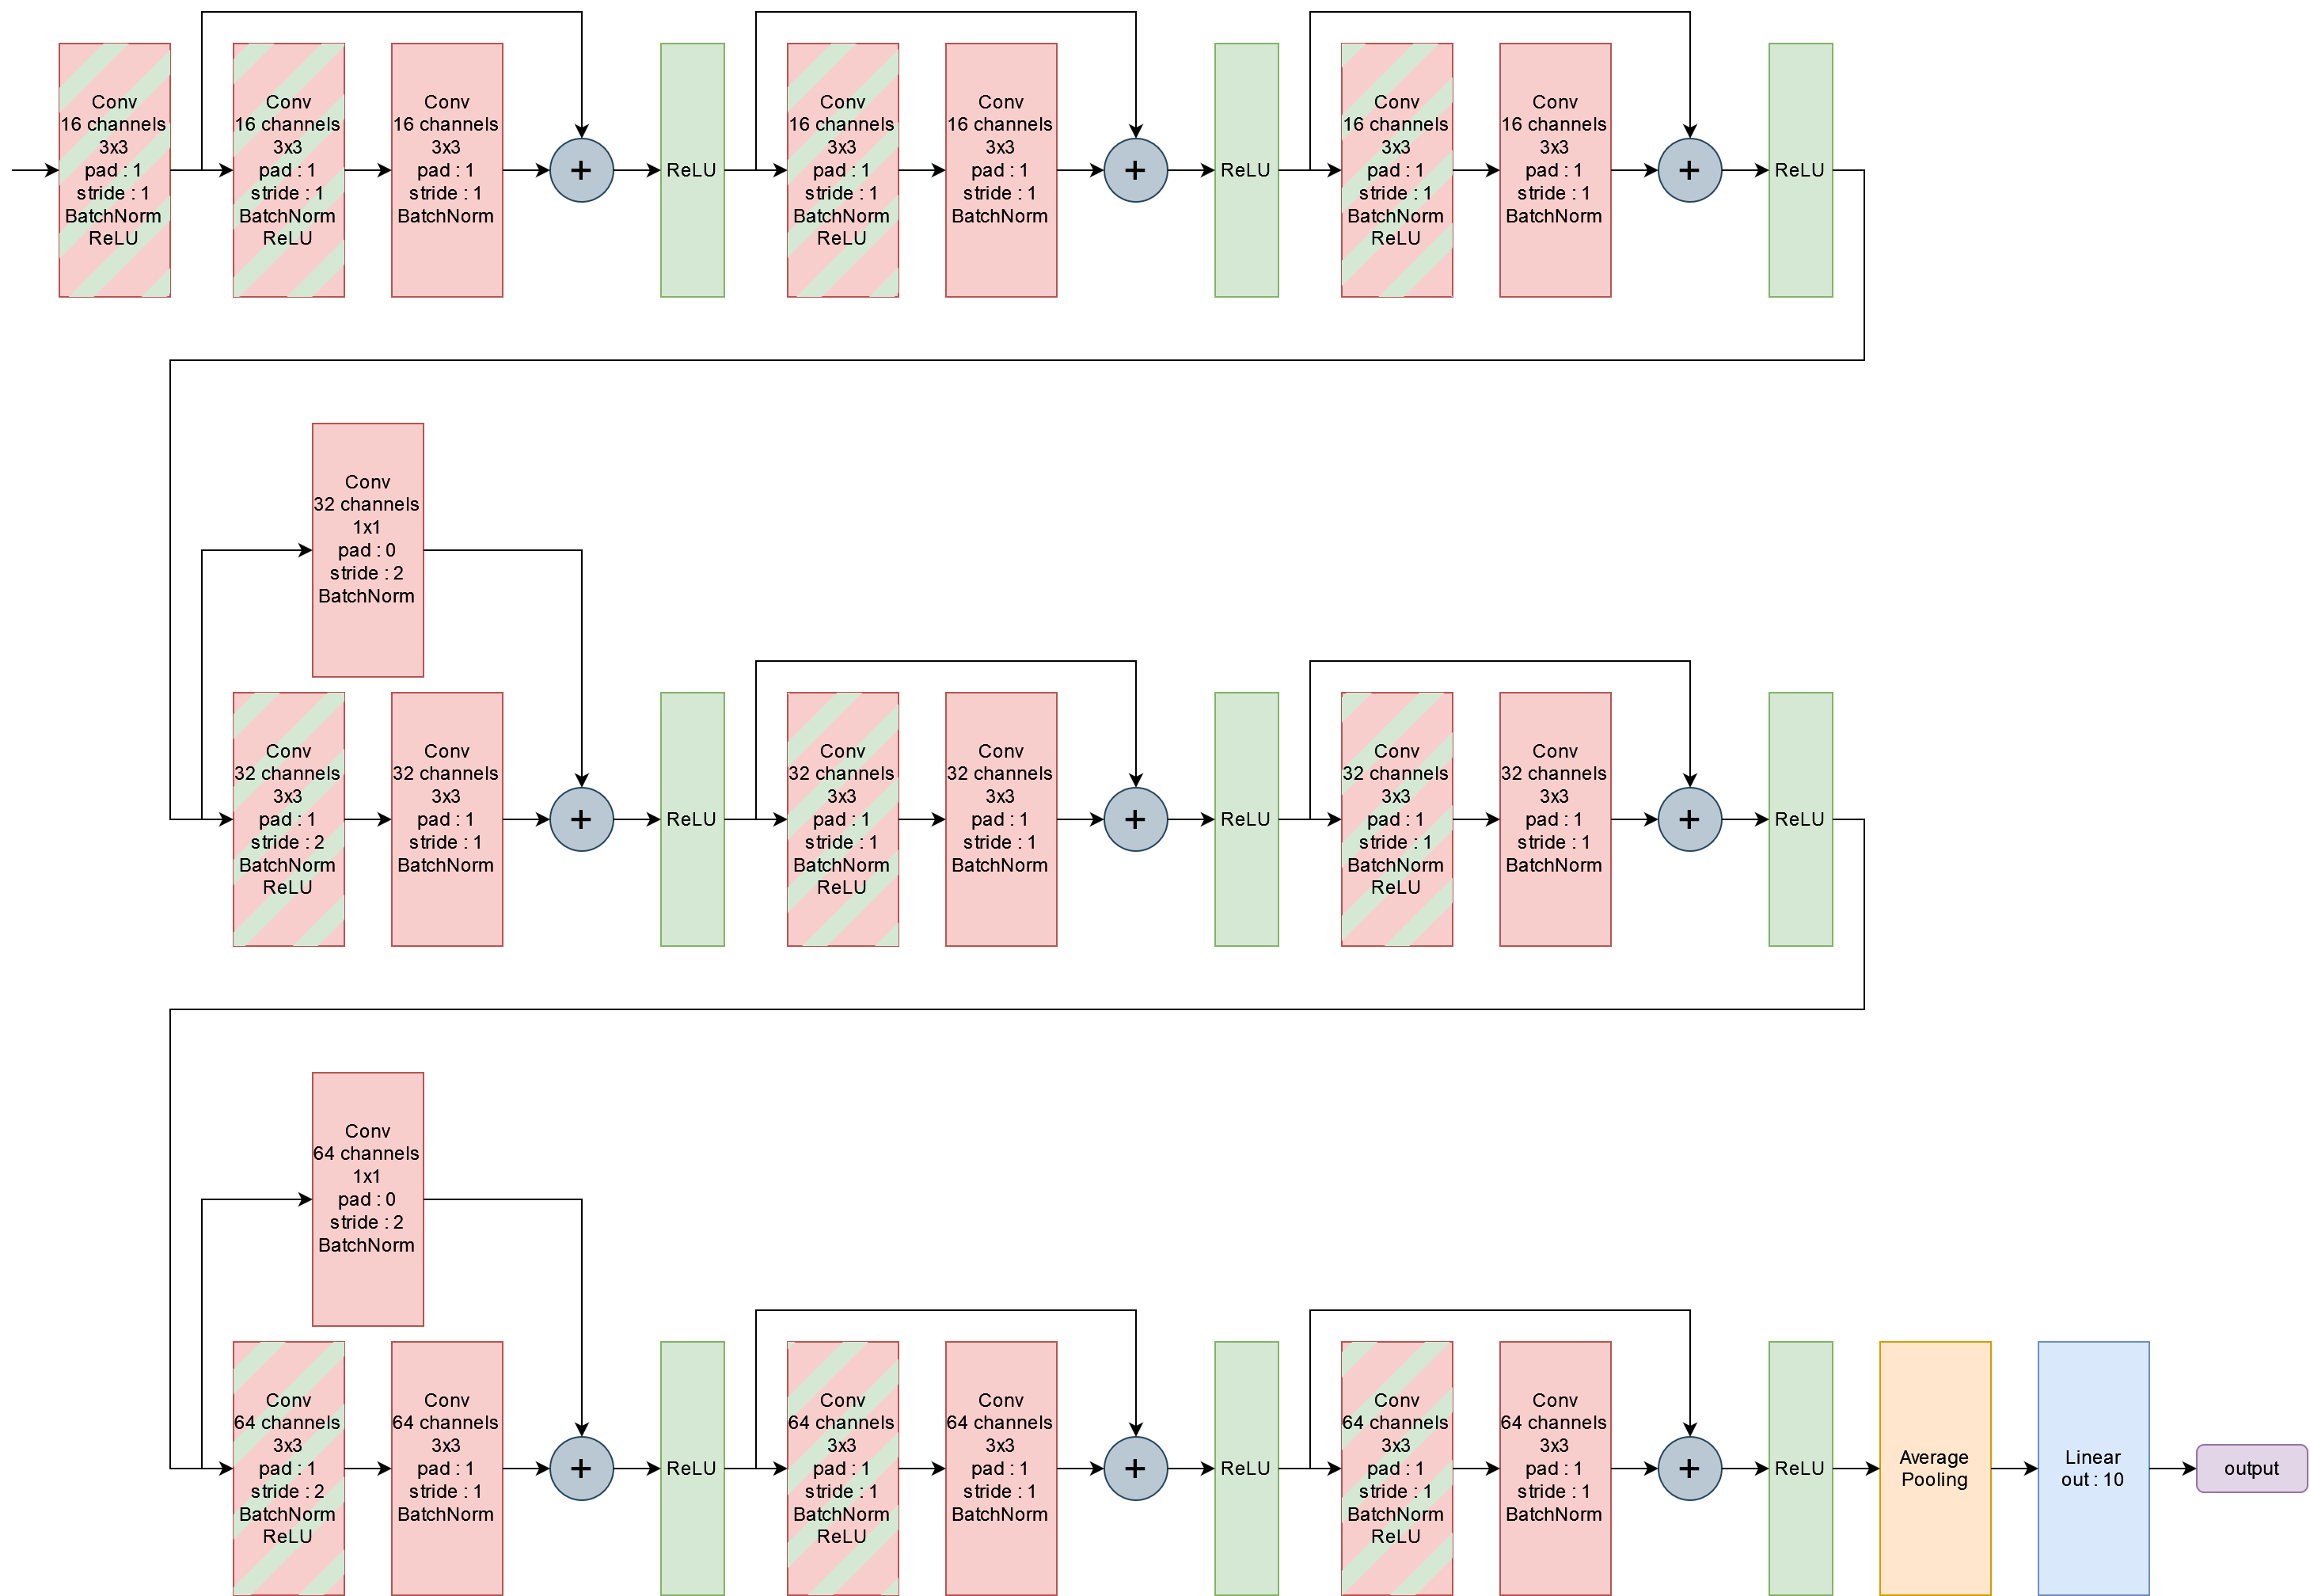

</div>

But even then, it is hard to read, although we already grouped convolutions with BatchNorms and ReLU when relevant. We can then further simplify :

<div style="max-width:800px;margin-right: auto; margin-left: auto;">

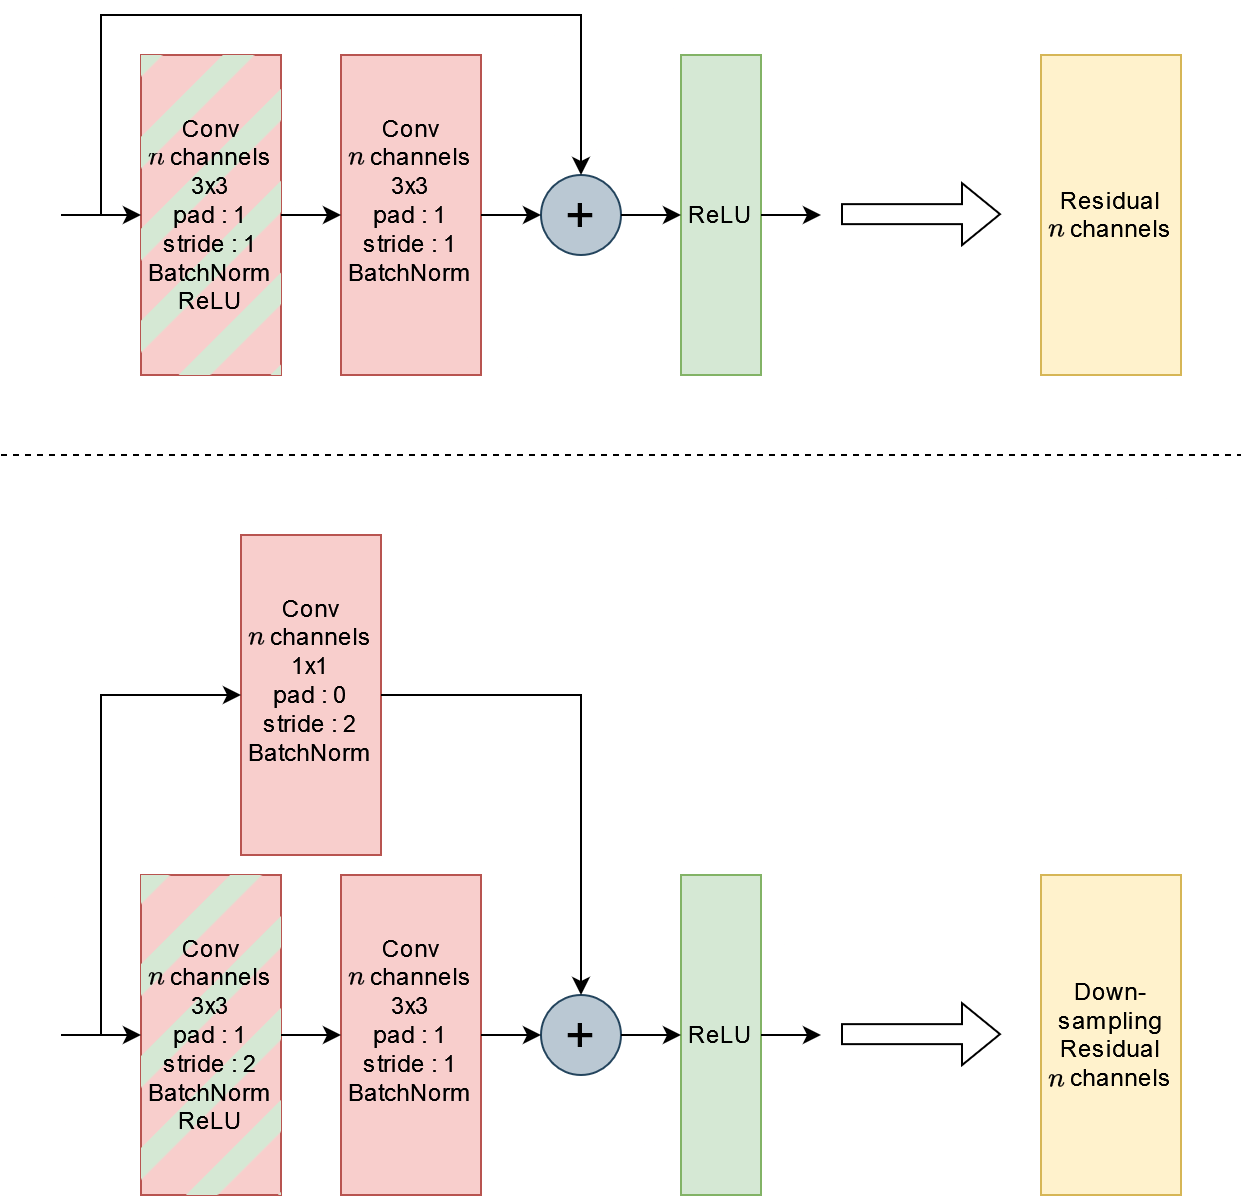

</div>

Leading to :

<div style="max-width:1200px;margin-right: auto; margin-left: auto;">

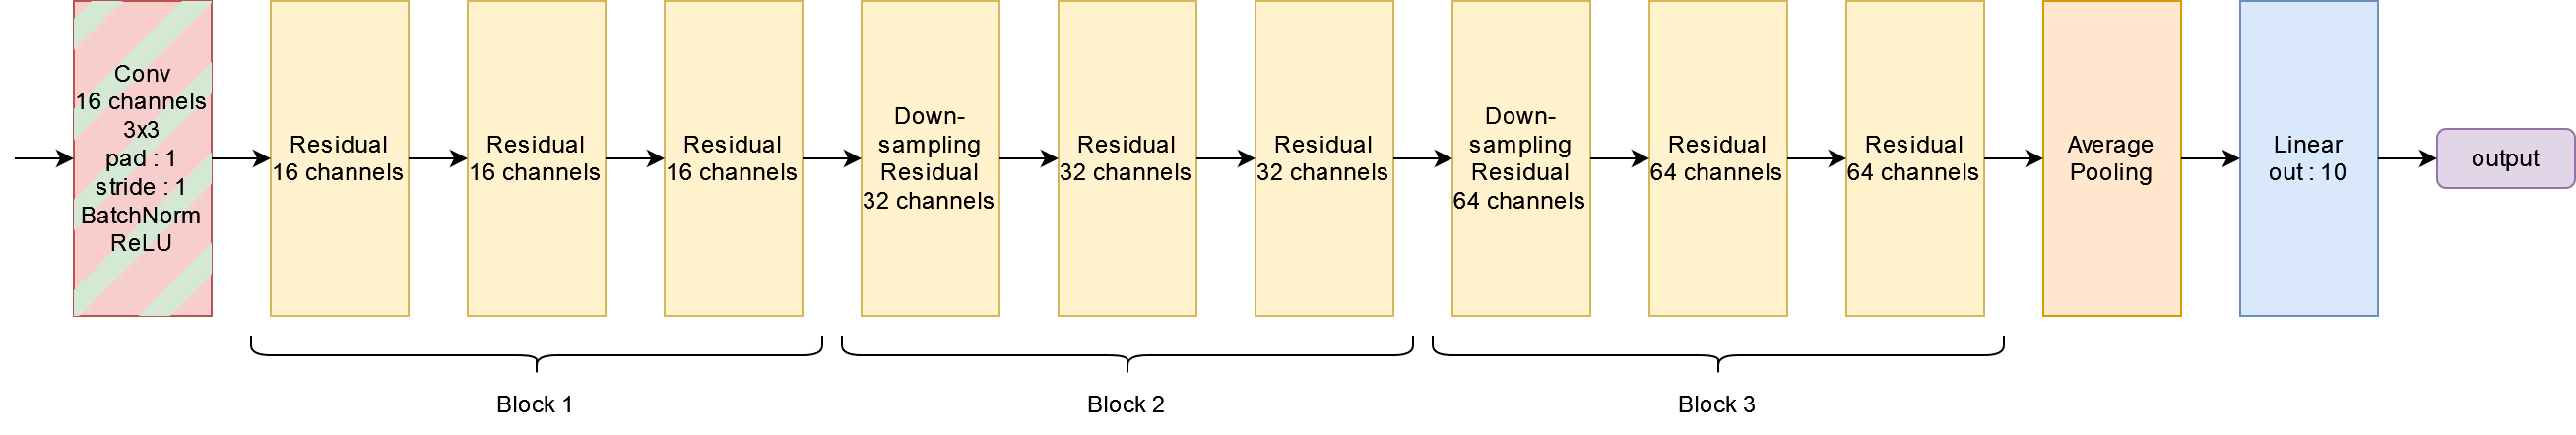

</div>

which provides a very clear and compact representation of the network, provided it is explained clearly what are the Residual and Downsampling Residual.

However, it happens, specifically for convolution networks, that other representations might be used. For example, it is possible to use the output size of each layer :

<div style="max-width:1200px;margin-right: auto; margin-left: auto;">

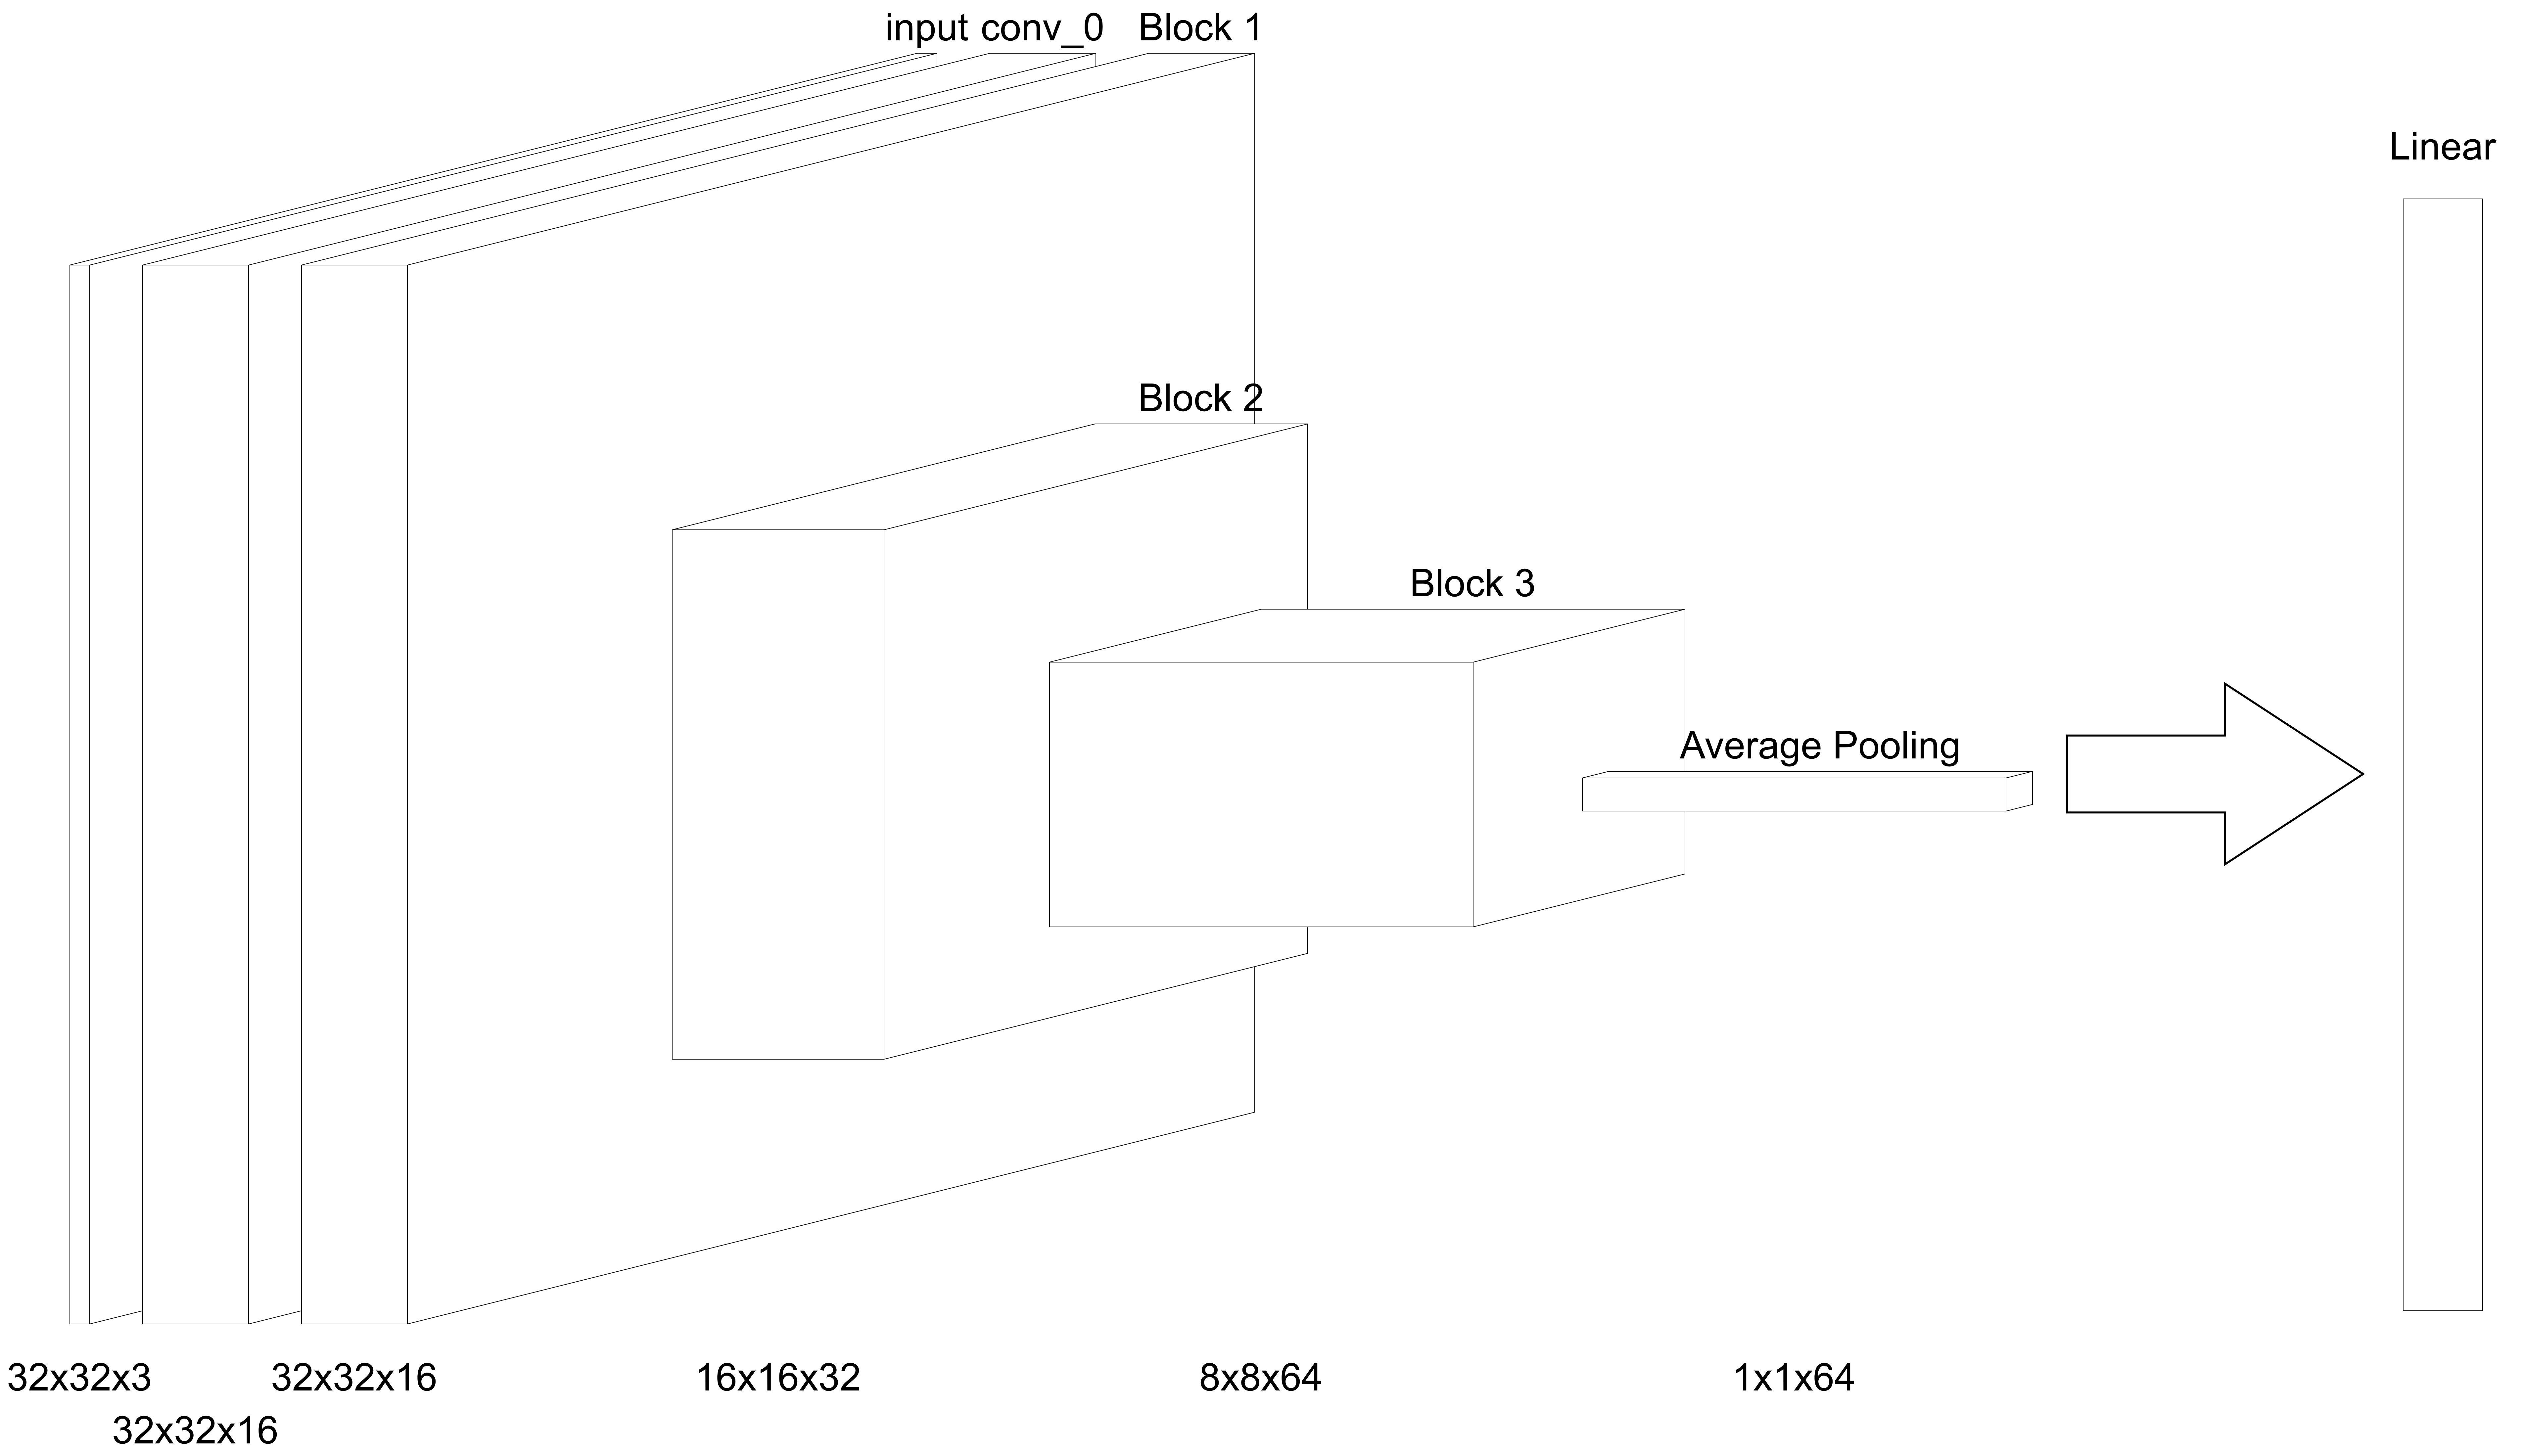

</div>

While this representation shows how the information compression goes in a very visual way, it does not account for the network precise architecture.

Sometimes, we represent the output blocks as well as the convolution kernels :

<div style="max-width:1500px;margin-right: auto; margin-left: auto;">

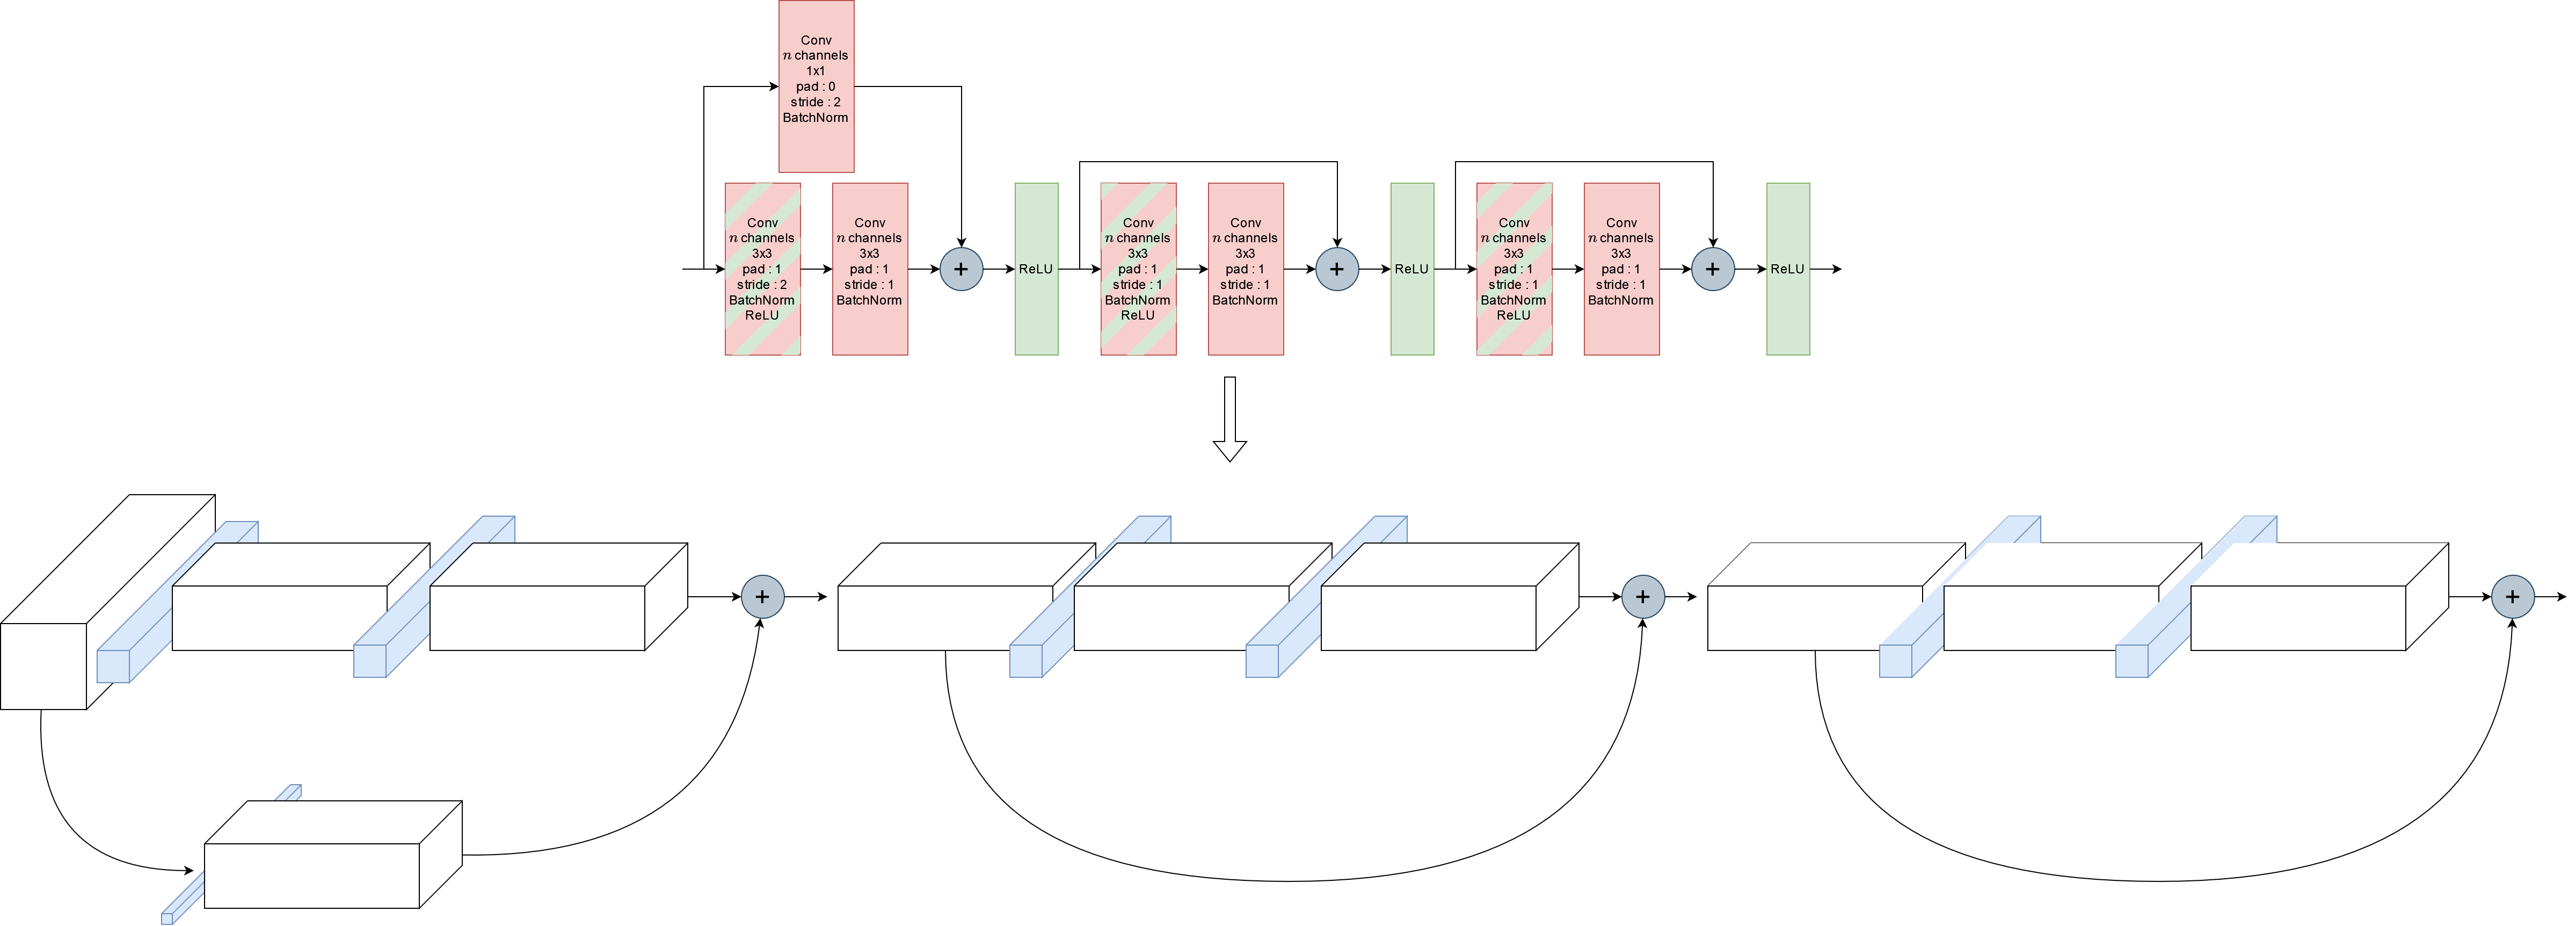

</div>

This representation is clearer than just the output blocks, but takes a lot of space. Also, it often contains annotations that are not here, to know the size of the kernels and the other parameters.

Finally, sometimes it is possible to encounter representations of convolutions that are closer to their mathematical/geometric meanings :

<div style="max-width:800px;margin-right: auto; margin-left: auto;">

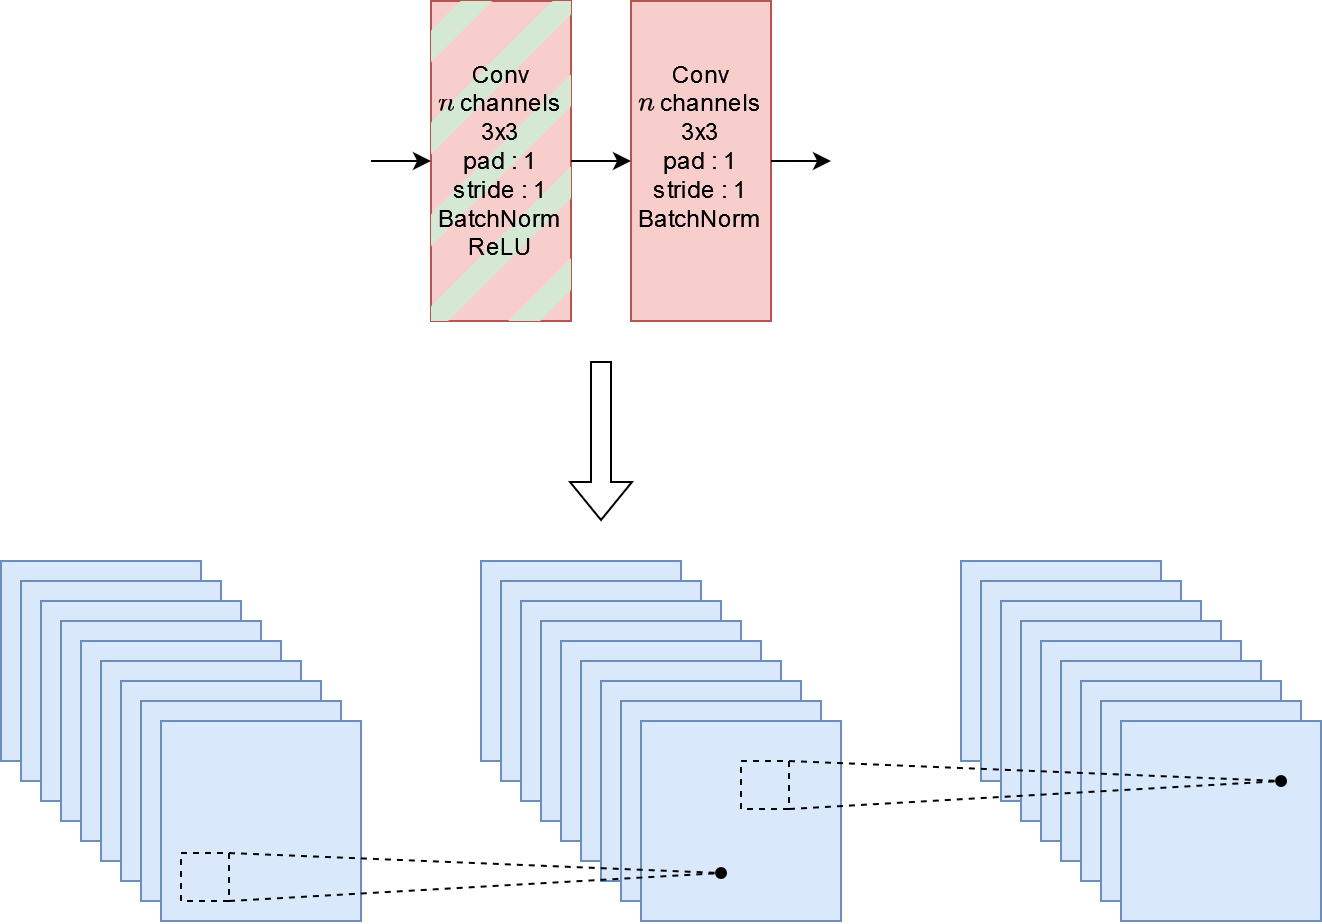

</div>

Here again, most often there are annotations to precise different things like kernel size, padding etc.

In the end, plenty of representations are possible. Keep in mind that what is important is to be able to rebuild the networks almost only by looking at those diagrams. This will allow the readers to understand very quickly the architecture of the network without having to bother reading everything in detail.

<h3 style="color:skyblue">Other common problems with neural networks and their results</h3>

Now that we have better representation of neural networks and better understanding of the control flow, we can get a better understanding of some problems.

It is common that sometimes, a network that learns doesn't reach stability or that it stops learning prematurely. Most often, this kind of issues (as long as some others) are tied to issues at the gradient level. While most of your code and pure value errors will happen in the forward pass and raise localised errors that are easy to debug, errors during the backward pass are harder to inspect. For errors that are raised, we encourage you to follow your debugging routine. If no errors are raised, then the problem might come from the gradients themselves, and we will provide tools to inspect them.

We will use another dataset, called [MNIST](https://doi.org/10.1109/MSP.2012.2211477), which is composed of 70000 28x28 black and white pictures of handwritten digits. 60000 are for training and 10000 for testing. The goal is to classify the images depending on the digit they picture.

In [ ]:
mnist_dataset_directory = Path("./datasets/MNIST")
mnist_dataset_directory.mkdir(parents=True, exist_ok=True)

mnist_train_set = torchvision.datasets.MNIST(
    root=mnist_dataset_directory,
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)
mnist_test_set = torchvision.datasets.MNIST(
    root=mnist_dataset_directory,
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

In [ ]:
plot_sample_grid(mnist_train_set, 5, seed)

In [ ]:
batch_size = 512

train_generator = torch.Generator().manual_seed(
    seed
)  # allows shuffling the training data in a reproducible way
mnist_trainloader = DataLoader(
    dataset=mnist_train_set,
    batch_size=batch_size,
    shuffle=True,
    generator=train_generator,
)

mnist_testloader = DataLoader(dataset=mnist_test_set, batch_size=batch_size)

We will create two networks, each with a problem that we might want to identify.

In [ ]:
class FirstFailingModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.n = 20
        self.lin1 = nn.Linear(in_features=(28 * 28), out_features=512)
        self.lin2 = nn.Linear(in_features=512, out_features=128)
        self.middle_lins = nn.ModuleList(
            [nn.Linear(in_features=128, out_features=128) for _ in range(self.n)]
        )
        self.lin3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, inputs: torch.Tensor):
        out = inputs.flatten(start_dim=1)
        out = torch.sigmoid(self.lin1(out))
        out = torch.sigmoid(self.lin2(out))
        for i in range(self.n):
            out = torch.sigmoid(self.middle_lins[i](out))
        out = torch.sigmoid(self.lin3(out))
        return out


first_network = FirstFailingModel()
optimizer = optim.AdamW(params=first_network.parameters())
loss = nn.CrossEntropyLoss()

In [ ]:
testloss, testacc, losses, accuracies = train(
    model=first_network,
    optimizer=optimizer,
    loss=loss,
    trainloader=mnist_trainloader,
    testloader=mnist_testloader,
    data_to_track=[("test", mnist_testloader)],
    num_epochs=15,
    device=device,
    verbose=True,
)

In [ ]:
print_results(testloss, testacc, losses, accuracies)

Here, we can see that the network does not learn. This is surprising, as the network has plenty plenty PLENTY of parameters, and should be able to learn quite precise things. To understand what is going wrong, we will track the gradients. We will redesign our training loop to include gradient tracking.

In [ ]:
# Modifying the training loop to store gradients


def train_with_gradtrack(
    model: nn.Module,
    optimizer: optim.Optimizer,
    loss: nn.Module,
    trainloader: DataLoader,
    testloader: DataLoader,
    data_to_track: list[tuple[str, DataLoader]],
    num_epochs: int,
    device: torch.device,
    verbose: bool = False,
) -> tuple[float, float, dict[str, list[float]], dict[str, list[float]], dict]:
    model.to(device=device)
    with torch.no_grad():

        # Initializing losses and accuracies

        losses = {"train": []}
        accuracies = {"train": []}

        grad_dict = {
            "batches": len(trainloader),
            "epochs": num_epochs,
            "layers": [],
        }
        for n, p in model.named_parameters():
            if p.requires_grad:
                grad_dict["layers"].append(n)

        for dataset_name, _ in data_to_track:
            losses[dataset_name] = []
            accuracies[dataset_name] = []

        for epoch in range(num_epochs):

            # training
            with torch.enable_grad():
                model.train()

                temp_acc = 0
                temp_losses = []
                for batch_id, (batch_data, batch_truth) in enumerate(trainloader):

                    # compute the output
                    # set the gradients to 0
                    # compute the loss
                    # compute the predicted classes

                    # === YOUR CODE ===
                    ...
                    loss_value = ...
                    predicted_classes = ...
                    # =================

                    temp_acc += (
                        torch.sum(predicted_classes == batch_truth.to(device))
                        .cpu()
                        .numpy()
                    )
                    temp_losses.append(loss_value.detach().cpu().numpy())

                    # compute the gradients

                    # === YOUR CODE ===
                    ...
                    # =================

                    # gradient tracking
                    ave_grads = []
                    max_grads = []
                    for _, p in model.named_parameters():
                        if p.requires_grad:
                            ave_grads.append(p.grad.abs().mean().cpu())
                            max_grads.append(p.grad.abs().max().cpu())
                    grad_dict[epoch, batch_id] = (ave_grads, max_grads)

                    # do a gradient step

                    # === YOUR CODE ===
                    ...
                    # =================

                    if verbose and ((batch_id + 1) % 100) == 0:
                        print(
                            f"Epoch[{epoch+1}/{num_epochs}], train batch[{batch_id+1}/{len(trainloader)}], loss : {loss_value.item()}"
                        )
                accuracies["train"].append(temp_acc / len(trainloader.dataset))
                losses["train"].append(np.mean(temp_losses))

            # data tracking across epochs, e.g. validation
            model.eval()
            for current_dataset_name, current_dataloader in data_to_track:
                temp_acc = 0
                temp_losses = []
                for batch_id, (batch_data, batch_truth) in enumerate(
                    current_dataloader
                ):

                    # compute the output
                    # compute the loss
                    # compute the predicted classes

                    # === YOUR CODE ===
                    ...
                    # =================

                    temp_acc += (
                        torch.sum(predicted_classes == batch_truth.to(device))
                        .cpu()
                        .numpy()
                    )
                    temp_losses.append(loss_value.detach().cpu().numpy())
                    if verbose and ((batch_id + 1) % 10) == 0:
                        print(
                            f"Epoch[{epoch+1}/{num_epochs}], {current_dataset_name} batch[{batch_id+1}/{len(current_dataloader)}], loss : {loss_value.item()}"
                        )
                accuracies[current_dataset_name].append(
                    temp_acc / len(current_dataloader.dataset)
                )
                losses[current_dataset_name].append(np.mean(temp_losses))

        # test
        model.eval()
        temp_acc = 0
        temp_losses = []
        for batch_id, (batch_data, batch_truth) in enumerate(testloader):

            # compute the output
            # compute the loss
            # compute the predicted classes

            # === YOUR CODE ===
            ...
            # =================

            temp_acc += (
                torch.sum(predicted_classes == batch_truth.to(device)).cpu().numpy()
            )
            temp_losses.append(loss_value.detach().cpu().numpy())
            if verbose and ((batch_id + 1) % 10) == 0:
                print(
                    f"test batch[{batch_id+1}/{len(testloader)}], loss : {loss_value.item()}"
                )
        testloss = np.mean(temp_losses)
        testacc = temp_acc / len(testloader.dataset)

    return testloss, testacc, losses, accuracies, grad_dict

In [ ]:
# Function to plot gradient flow

from typing import Union

from matplotlib.lines import Line2D
from matplotlib.widgets import Slider


def plot_grad_flow(
    grad_dict: dict,
    height: Union[int, float] = 5,
    width: Union[int, float] = 7,
    upper_bound: Union[int, float] = 0.02,
) -> None:
    r"""Allow an interactive plot of the gradient received by the parameters of the model.
    Epoch and batch can be selected through sliders.
    Due to interactivity of matplotlib required for this to work properly, it may encounter problems with some IDE.
    """
    n = len(grad_dict["layers"])
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={"width_ratios": [200, 1, 1]})
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax1.set_xlabel("Layers")
    ax1.set_ylabel("Average gradient")
    max_bar = ax1.bar(
        np.arange(n),
        grad_dict[0, 0][1],
        alpha=0.5,
        lw=1,
        color="c",
        label="Max gradient",
    )
    ave_bar = ax1.bar(
        np.arange(n),
        grad_dict[0, 0][0],
        alpha=0.5,
        lw=1,
        color="b",
        label="Mean gradient",
    )
    nan_bar = ax1.bar(
        np.arange(n),
        np.logical_or(np.isnan(grad_dict[0, 0][1]), np.isnan(grad_dict[0, 0][0])),
        alpha=0.5,
        lw=1,
        color="r",
        label="NaN gradient",
    )
    ax1.hlines(0, 0, n + 1, lw=2, color="k")
    ax1.set_xticks(range(0, n, 1), grad_dict["layers"], rotation="vertical")
    ax1.set_xlim(left=0, right=n)
    ax1.set_ylim(bottom=-upper_bound / 20, top=upper_bound)
    ax1.set_title("Gradient flow")
    ax1.grid(True)
    ax1.legend(
        [
            Line2D([0], [0], color="c", lw=4),
            Line2D([0], [0], color="b", lw=4),
            Line2D([0], [0], color="k", lw=4),
            Line2D([0], [0], color="r", lw=4),
        ],
        ["Max gradient", "Mean gradient", "Zero", "NaN gradient"],
        ncol=3,
        loc="best",
    )  # , bbox_to_anchor=(1.2, 1.2), mode="expand", borderaxespad=0)

    epoch_slider = Slider(
        ax=ax2,
        label="Epoch",
        valmin=1,
        valmax=grad_dict["epochs"],
        valinit=1,
        valstep=1,
        orientation="vertical",
    )

    batch_slider = Slider(
        ax=ax3,
        label=" Batch",
        valmin=1,
        valmax=grad_dict["batches"],
        valinit=1,
        valstep=1,
        orientation="vertical",
    )

    def update(val):
        nans = np.logical_or(
            np.isnan(grad_dict[epoch_slider.val - 1, batch_slider.val - 1][1]),
            np.isnan(grad_dict[epoch_slider.val - 1, batch_slider.val - 1][0]),
        )
        for i in range(n):
            max_bar[i].set_height(
                grad_dict[epoch_slider.val - 1, batch_slider.val - 1][1][i]
            )
            ave_bar[i].set_height(
                grad_dict[epoch_slider.val - 1, batch_slider.val - 1][0][i]
            )
            nan_bar[i].set_height(nans[i])
        fig.canvas.draw_idle()

    epoch_slider.on_changed(update)
    batch_slider.on_changed(update)

    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = "top"

    plt.tight_layout(w_pad=0)

In [ ]:
testloss, testacc, losses, accuracies, grad_dict = train_with_gradtrack(
    model=first_network,
    optimizer=optimizer,
    loss=loss,
    trainloader=mnist_trainloader,
    testloader=mnist_testloader,
    data_to_track=[("test", mnist_testloader)],
    num_epochs=15,
    device=device,
    verbose=True,
)

In [ ]:
%matplotlib ipympl

plot_grad_flow(grad_dict)

In [ ]:
# execute this cell whenever you finished inspecting the gradients, it will reset matplotlib to non-interactive but will free some memory and processor time

%matplotlib inline

Here, we can see that the gradient does not go deeper than the few last linear layers. The gradient quickly drops to zero, this is the vanishing gradient problem. Here, this is linked to two different things :
- the network is quite deep
- the activation is the Sigmoid function, which derivative quickly goes to zero

Hence, across the layers, the gradients are becoming smaller and smaller until they numerically reach zero (due to floating point precision). To avoid this, it is often recommended to switch to a more suitable architecture or activation function.

We will now design another network.

In [ ]:
class SecondFailingModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.n = 3
        self.lin1 = nn.Linear(in_features=(28 * 28), out_features=512)
        self.lin2 = nn.Linear(in_features=512, out_features=128)
        self.middle_lins = nn.ModuleList(
            [nn.Linear(in_features=128, out_features=128) for _ in range(self.n)]
        )
        self.lin3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, inputs: torch.Tensor):
        out = inputs.flatten(start_dim=1)
        out = F.leaky_relu(self.lin1(out))
        out = F.leaky_relu(self.lin2(out))
        for i in range(self.n):
            out = F.leaky_relu(self.middle_lins[i](out))
        out = self.lin3(out)
        return out


second_network = SecondFailingModel()
optimizer = optim.SGD(params=second_network.parameters(), lr=0.01, momentum=1)
loss = nn.CrossEntropyLoss()

In [ ]:
testloss, testacc, losses, accuracies, grad_dict = train_with_gradtrack(
    model=second_network,
    optimizer=optimizer,
    loss=loss,
    trainloader=mnist_trainloader,
    testloader=mnist_testloader,
    data_to_track=[("test", mnist_testloader)],
    num_epochs=15,
    device=device,
    verbose=True,
)

In [ ]:
print_results(testloss, testacc, losses, accuracies)

In [ ]:
%matplotlib ipympl

plot_grad_flow(grad_dict)

In [ ]:
# execute this cell whenever you finished inspecting the gradients, it will reset matplotlib to non-interactive but will free some memory and processor time

%matplotlib inline

Here, we can see that the gradient increases with time, leading to bigger and bigger weights. Eventually, this results in numbers bigger than the floating point limit, and gives NaN (Not a Number) values. This is what is called gradient explosion. Sometimes, it does not reach NaN values, but instead only stay very unstable. Gradient explosion has several sources :
- a learning step that is too big
- weights that were initialized at too high values
- lack of gradient clipping/momentum decay
- batches too big
- poor loss desgin/lack of weights regularization

It is indeed possible to force gradient to not explode by clipping them (put a ceiling to their value), but also by regularizing the network weights. Regularization is just putting a loss on weights that are too big, like the norm of the weights. That way, if the weights become too big, the regularization loss will propagate gradients to make them smaller.

While other problems might arise from the gradients, gradient vanish and gradient explosion are the two main issues you might face. However, with the tools presented here, it is possible to inspect the gradients to determine what is happening, and at which layer in the network.